# Visualize CryinGAN training

In [152]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import ase
from ase.io import read, write
from ase.visualize import view

Number of runs:  1


<Axes: xlabel='epoch'>

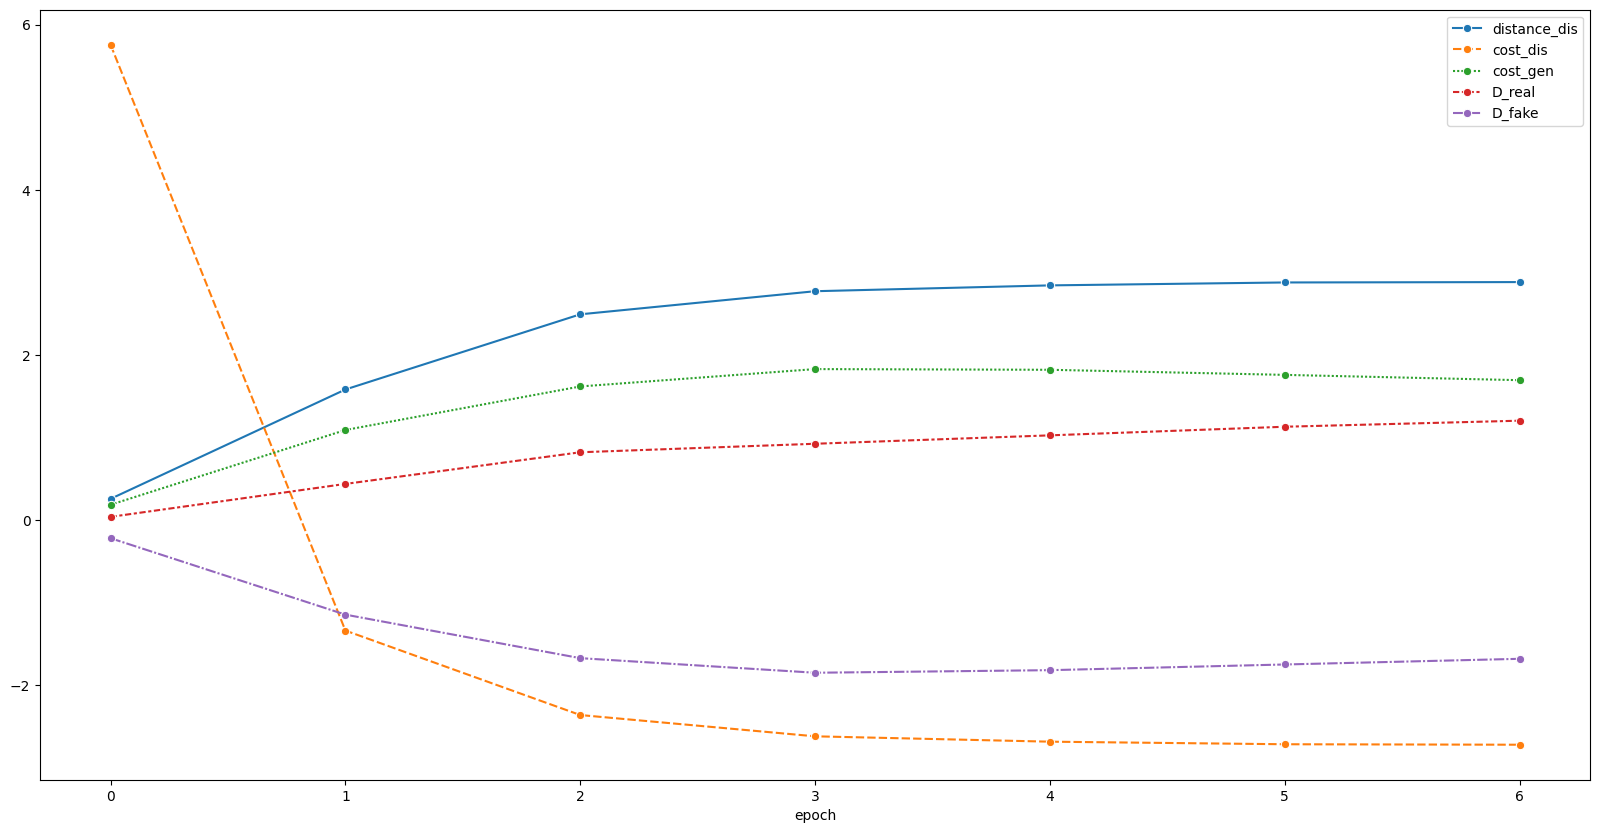

In [157]:
all_runs = pd.read_csv("../CryinGAN/losses.csv") # For full scale test
all_runs = pd.read_csv("../ConditionedCryinGAN/losses.csv") # For square lattice

run_starts = all_runs["epoch"] == "epoch"

# Filter out the rows that are not part of the runs
# all_runs = all_runs[~run_starts]

# Add "run" column
all_runs["run"] = 0

run_idx = 0

for i in range(1,len(all_runs)):
    if run_starts[i]:
        all_runs.loc[i:, "run"] = run_idx
        run_idx += 1
    else:
        all_runs.loc[i, "run"] = run_idx

print("Number of runs: ", all_runs["run"].max() + 1)
# Remove the first row of each run
all_runs = all_runs[~run_starts]
all_runs["epoch"] = all_runs["epoch"].astype(int)
all_runs.set_index(["run", "epoch"], inplace=True)
all_runs = all_runs.astype(float)

# Read and visualize losses csv

run_idx = 0 # CHANGE THIS TO SELECT A RUN
df = all_runs.loc[run_idx]

fig = plt.figure(figsize=(20,10))
sns.lineplot(data=df, figure=fig, marker="o")
# plt.grid(which="both")


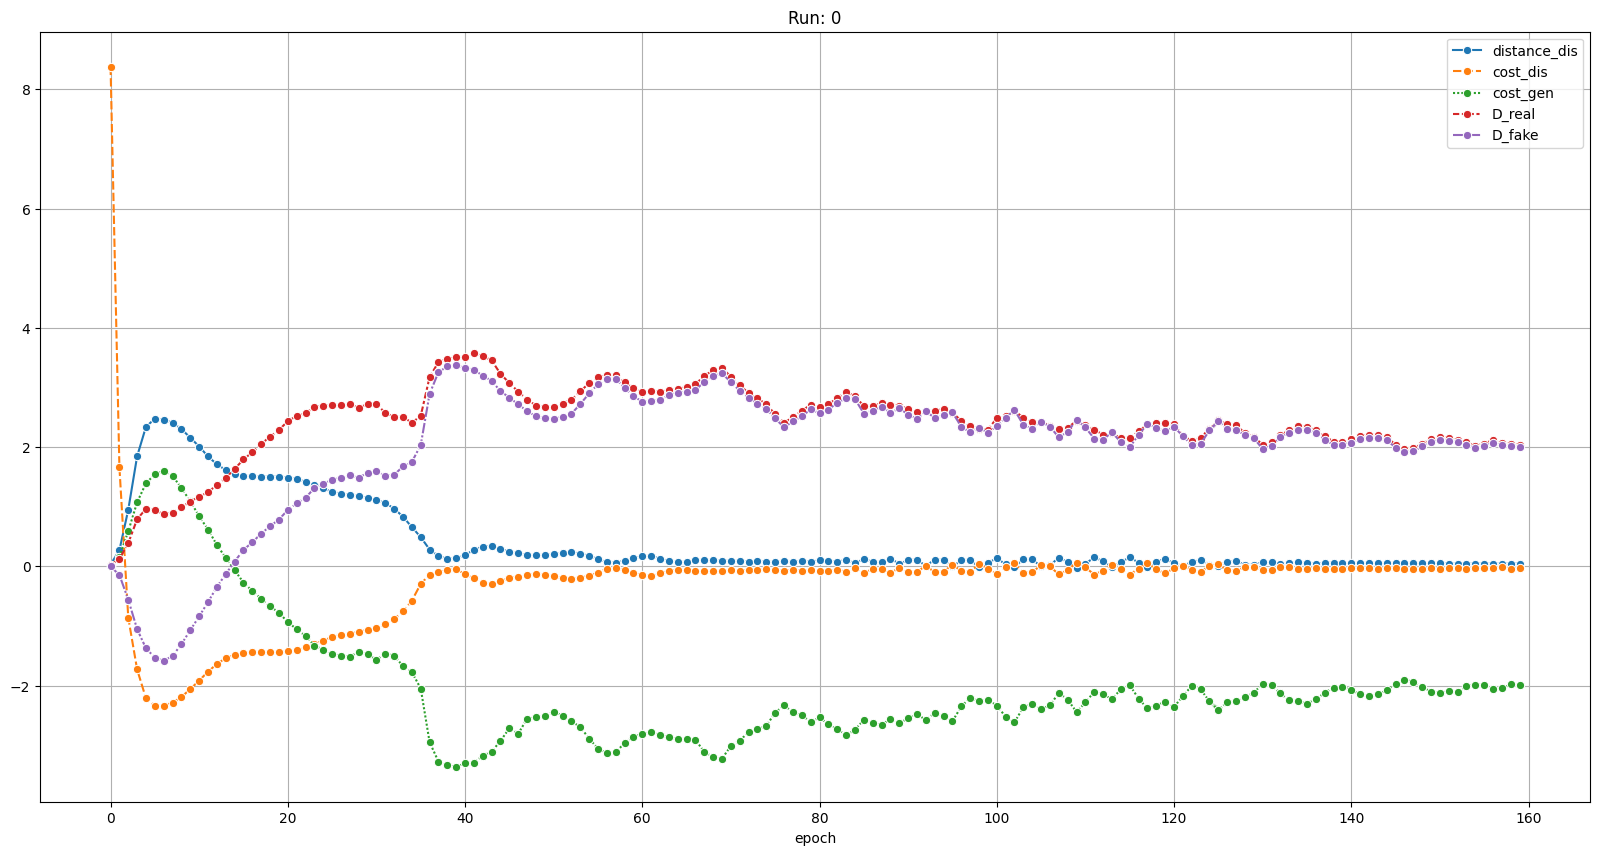

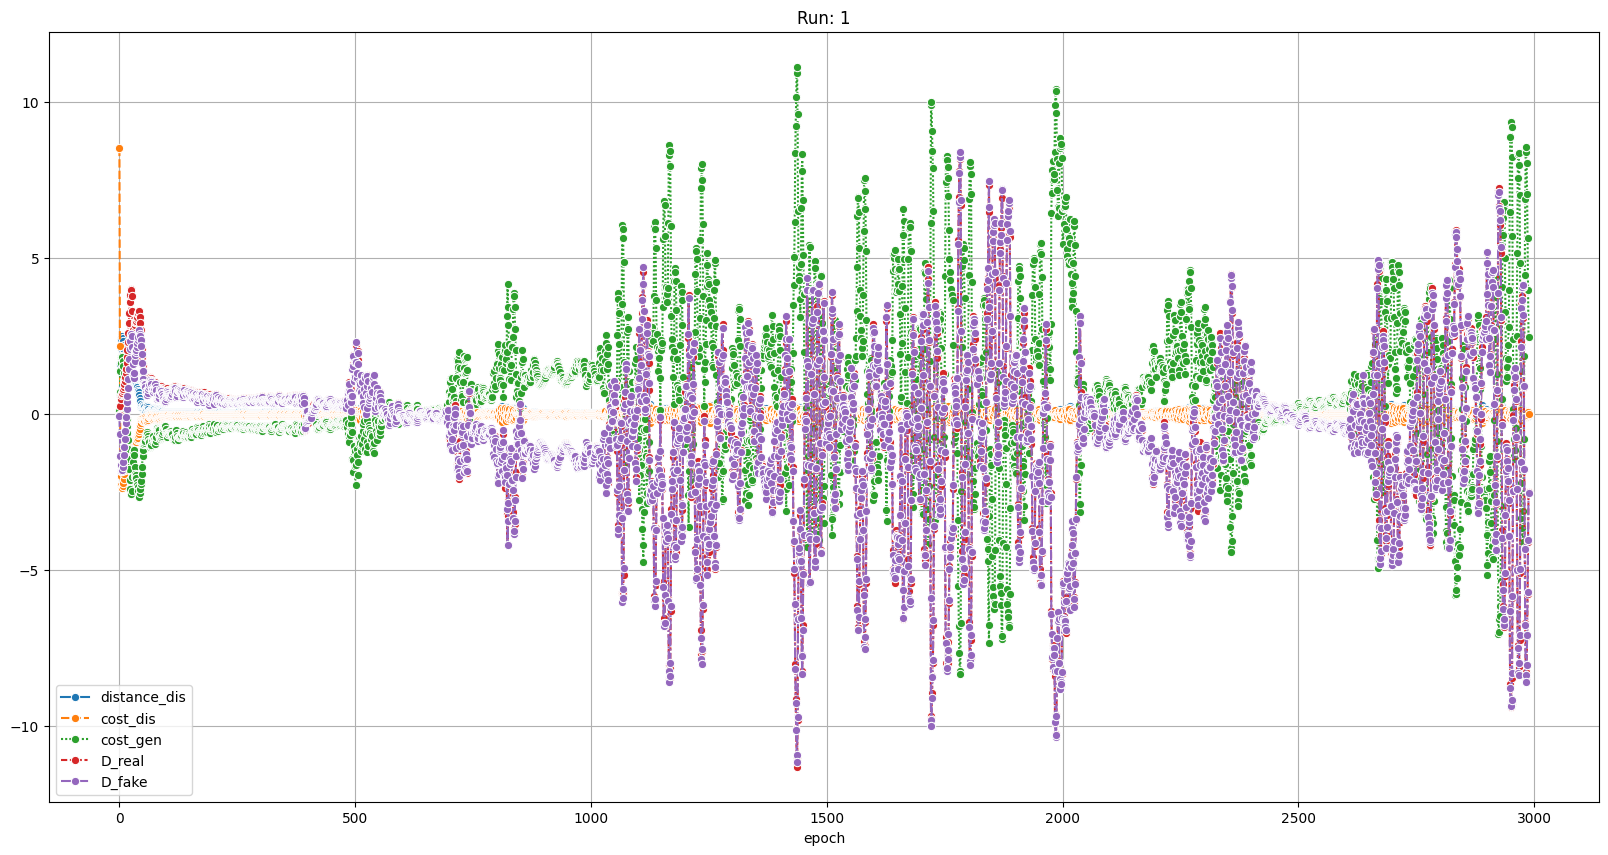

In [119]:
for run_idx in all_runs.index.levels[0].unique():
    df = all_runs.xs(key=run_idx, level="run")

    fig = plt.figure(figsize=(20,10))
    sns.lineplot(data=df, figure=fig, marker="o")
    plt.gca().set_title(f"Run: {run_idx}")
    plt.grid(which="both")

## Check on the generated structures

Numpy way from training-time generation

In [ ]:
ref_struct = read("../data/reference/cryingan_train.extxyz", index=1, format="extxyz")
ref_struct = read("../data/processed/crystal/Sq/phi-0.84/disorder-0.2", index=1, format="extxyz")
ref_struct = read("../data/processed/samples/phi-0.84", index=1, format="extxyz")

view(ref_struct,  viewer="x3d", show_unit_cell=True, repeat=(1,1,1))

Python(29598) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


<Popen: returncode: None args: ['/Users/veikko/Documents/GitHub/hard-spheres...>

In [ ]:
import numpy as np
file = "../CryinGAN_COPY/gen_data/gen_coords_625.npy"
file = "../CryinGAN/gen_data/gen_coords_3700.npy"
np_coords = np.load(file)
atoms = ref_struct.copy()
idx = 1 # Pick one generated sample
atoms.set_scaled_positions(np_coords[idx,0])
view(atoms,  viewer="x3d", show_unit_cell=True, repeat=(1,1,1))

Python(29680) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


<Popen: returncode: None args: ['/Users/veikko/Documents/GitHub/hard-spheres...>

Make a movie

In [61]:
import glob

atoms_list = []
idx = 2 # Pick one generated sample

for file in glob.glob("../CryinGAN/gen_data/gen_coords_*.npy"):
    np_coords = np.load(file)
    atoms = ref_struct.copy()
    atoms.set_scaled_positions(np_coords[idx].squeeze())

    atoms_list.append(atoms)
    # view(atoms, viewer="x3d", show_unit_cell=True, repeat=(1,1,1))

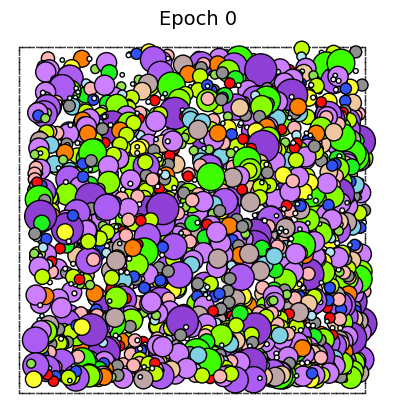

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from ase.visualize.plot import plot_atoms
from ase import Atoms
from ase.io import read

fig, ax = plt.subplots()

def update(i):
    ax.clear()
    plot_atoms(atoms_list[i], ax, rotation=('0x,0y,0z'), show_unit_cell=2)
    ax.set_axis_off()
    ax.set_title(f'Epoch {i*5}', fontsize=14)

ani = animation.FuncAnimation(fig, update, frames=len(atoms_list), interval=200)

ani.save('annotated_movie.gif', writer='pillow')

In [ ]:
file = "../data/reference/cryingan_train.extxyz" # For reference data
file = "../data/processed/samples/phi-0.84" # For reference data
file = "../CryinGAN/gen.extxyz" # For generated data
file = "../ConditionedCryinGAN/gen-phi-0.70.extxyz" # For generated data
file = "../ConditionedCryinGAN/gen-phi-0.84.extxyz" # For generated data

all_atoms = read(file, index=":", format="extxyz")
print("Read {} atoms".format(len(all_atoms)))

IDX = 1
atoms = all_atoms[IDX]

view(atoms, viewer="x3d", show_unit_cell=True, repeat=(1,1,1))

Read 50 atoms


# Next steps

1. Provide Anshul with generated samples (50 each) in our data format
   1. Low packing fraction 0.70
   2. Mid 0.78
   3. High packing fraction 0.84
   4. Very high 0.86
2. Special assignment: Try out different loss functions to make the generated structures more physically feasible (or something else)
   1. Adding the bond distance discriminator
   2. Radius / overlap loss
   3. NN distance based loss
   4. Hexatic (k=5) order loss
   5. Other physical 
3. (Later: Conditioning on phi / other descriptors)

In [ ]:
# Save the coordinates to a CSV file

import os
# os.mkdir("../data/gen")
# os.mkdir("../data/gen/phi-0.84")

for i in range(len(all_atoms)):
    with open(f"../data/gen/phi-0.84/sample-{i}", "w+") as f:
        
        atoms = all_atoms[i]

        L = atoms.get_cell()[0][0]
        N = len(atoms)

        header = "\t{N}\t{L}\t1626.81570886301\t\n".format(N=N, L=L)
        f.write(header)

        _df = pd.DataFrame({
            "class": atoms.get_atomic_numbers(),
            "x": atoms.get_positions()[:,0],
            "y": atoms.get_positions()[:,1],
        }).to_csv(f, index=False, header=False, sep="\t")
